# STARE-based Integrative Analysis of Diverse Data Using Dask Parallel Programming Demo Paper

## Preliminaries

In [1]:
import pystare as ps

from netCDF4 import Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf

import geodata as gd

import numpy

from PIL import Image
Image.MAX_IMAGE_PIXELS = None


import os
import sys
import glob
from io import BytesIO

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely

%matplotlib inline
# %matplotlib notebook

In [3]:
def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

# Some helper functions for plotting & printing.

def mnmx(a):
    return numpy.amin(a),numpy.amax(a)
def span(a):
    return numpy.amax(a)-numpy.amin(a)

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options=None
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ,dbg=0
        ,fixdateline=False
        ,figsize=None
        ):

    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        if dbg>0:
            print('lons: ',mnmx(lons))
            print('lats: ',mnmx(lats))
            # print('lons: ',lons)
            # print('lats: ',lats)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))

    if figax is not None:
        plot_options = figax.plot_options
    
    if plot_options is None:
        if spatial_index_values is not None:
            mnx  = mnmx(lons)
            if fixdateline:
                s = span(lons)
                if s > 270:
                    clon = ((0.5 * (sum(mnx)+180))%360)-180
                else:
                    clon = 0.5*sum(mnx)
            else:
                clon = 0.5*sum(mnx)
            plot_options = {
                'projection':ccrs.PlateCarree(
                    central_longitude=clon
                    # ,central_latitude=0.5*(numpy.amin(lats)+numpy.amax(lats))
                                             )
            ,'transform':ccrs.Geodetic()}
            if dbg>0:
                print('hp-po central_longitude: ',clon)
        else:
            plot_options = {'projection':ccrs.PlateCarree()
                           ,'transform':ccrs.Geodetic()}

        
    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=figsize),plot_options=plot_options)
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax  
        
    if spatial_index_values is not None: 
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
        restore_stderr()
    
    if show:
        plt.show()
        
    if dbg>0:
        return figax,lons,lat,intmat
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [4]:
class merra2_sidecar(object):
    def __init__(self,cover_resolution = 0):
        self.nlat = 361
        self.nlon = 576
        self.dlat = 0.5 # or 180.0/(nlat-1)
        self.dlon = 5.0/8.0 # or 360.0/(nlon)
        self.lat1d = self.dlat*numpy.arange(self.nlat)-90.0
        self.lon1d = self.dlon*numpy.arange(self.nlon)-180.0
        self.dLatkm = self.dlat * gd.re_km/gd.deg_per_rad
        self.dLonkm  = self.dlon * gd.re_km/gd.deg_per_rad
        self.lat,self.lon = numpy.meshgrid(self.lat1d,self.lon1d)
        self.lat_flat     = self.lat.flatten()
        self.lon_flat     = self.lon.flatten()
        self.idx_ij       = numpy.arange(self.lat_flat.size,dtype=numpy.int64)
        self.resolution   = int(gd.resolution(self.dLonkm*2))
        self.cover_resolution = cover_resolution
        self.index        = ps.from_latlon(self.lat_flat,self.lon_flat,self.resolution)
        di = ps.spatial_increment_from_level(self.cover_resolution)
        self.cover        = [self.cover_resolution+(i*di) for i in range(8*(4**self.cover_resolution))]
        

## STARE HTM Geolocation

- htm = ... 
- trixel -- spatial part
- Like hello earth -- link to the cookbook.
- Root level, octahedron
- Just to explain
- title -- projected octahedron
explain, high level info
what's the motivation here
- the neighborhood part -- geolocation always indexed at the leaf of the hierarchy

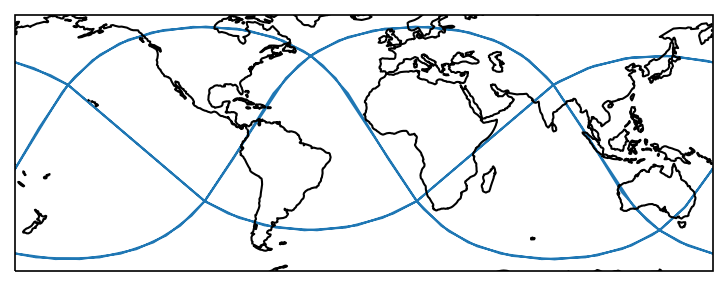

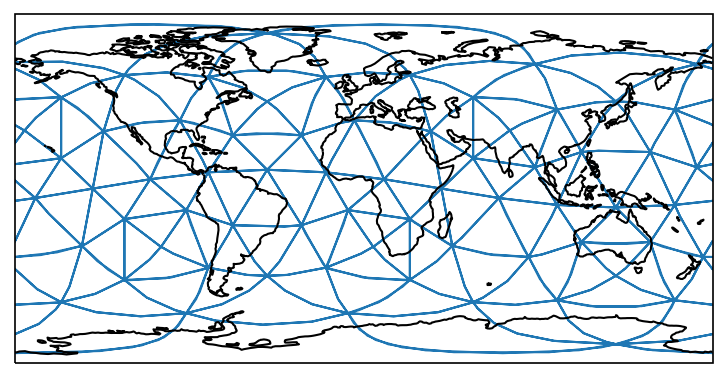

In [5]:
def trixels_at_level(cover_resolution = 0):
    di = ps.spatial_increment_from_level(cover_resolution)
    cover = [cover_resolution+(i*di) for i in range(8*(4**cover_resolution))]
    hello_plot(cover)
    return cover
    
cover = trixels_at_level(0)
cover = hello_plot([1+(i*ps.spatial_increment_from_level(1)) for i in range(4)])
cover = trixels_at_level(1)
cover = trixels_at_level(2)

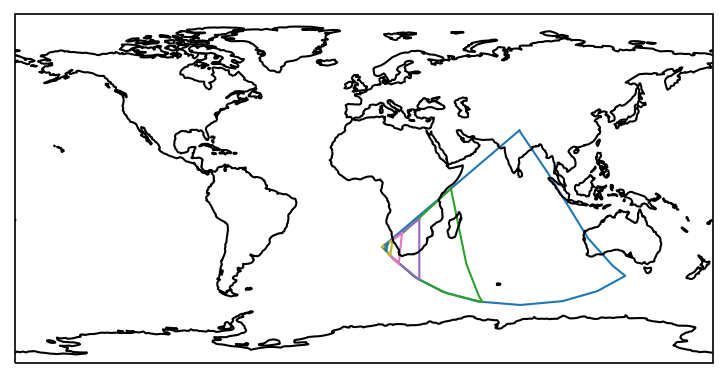

In [6]:
figax = hello_plot(show=False,set_global=True)
for i in range(10):
    figax = hello_plot([i],figax=figax,show=False)
plt.show()

## STARE HTM Trixel Neighborhoods

In [7]:
# Set longitude and latitude in degrees to the summit of Mauna Loa.
lon = -155.602778
lat =   19.479444

# Set the length scale of a neighborhood triangular element (trixel) about the location.
resolution_scale_km = 1000*km

# Determine the resolution, i.e. the level of the spatial quadtree, of that length scale.
spatial_resolution_level = int(ps.spatial_resolution_from_km(resolution_scale_km))

# Calculate the spatial index value.
spatial_id = ps.from_latlon([lat],[lon],spatial_resolution_level)

# Print to check.
print('resolution (%f km) ~ level = %i, (float %f)'%(resolution_scale_km
                                          ,spatial_resolution_level
                                          ,ps.spatial_resolution_from_km(resolution_scale_km)))
print('(lon,lat)=(%f,%f) -> spatial_id = %s'%(lon,lat,hex16(spatial_id[0])))
print()
print('Full spatial id:              %s'%(hex16(spatial_id[0])))
print('Geolocation part (bits 61-5): %s'%(hex16(spatial_id[0] & (~31))))
print('Resolution part  (bits  4-0): %s'%(hex16(spatial_id[0] & ( 31))))



resolution (1000.000000 km) ~ level = 3, (float 3.356144)
(lon,lat)=(-155.602778,19.479444) -> spatial_id = 0x2c2401f47797ec43

Full spatial id:              0x2c2401f47797ec43
Geolocation part (bits 61-5): 0x2c2401f47797ec40
Resolution part  (bits  4-0): 0x0000000000000003


In [8]:
# Plot the trixel associated with the spatial index value
figax = hello_plot(show=False,plot_options=plot_options)
figax = hello_plot(spatial_id,figax=figax,show=False)

# Go to a finer resolution
if False:
    figax = hello_plot(spatial_id+1,figax=figax,show=False)

# Go to finer resolutions, all the way to level=10, 10km.
if False:
    for lvl in range(8):
        figax = hello_plot(spatial_id+2+lvl,figax=figax,show=False)

# Plot the geolocation (lon,lat) as a red dot.
figax.ax.scatter([lon],[lat],s=10,c='r',transform=plot_options['projection'])
plt.show()

## Gridded Earth Science Data

-- high level vs. low level
-- coarse resolution 0.5x5/8
-- 0 to ~50km pole to eq.



In [9]:
ds = starepandas.nc4_Dataset_wrapper("s3://daskhub-data/GESDISC/MERRA2/2019/MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4")

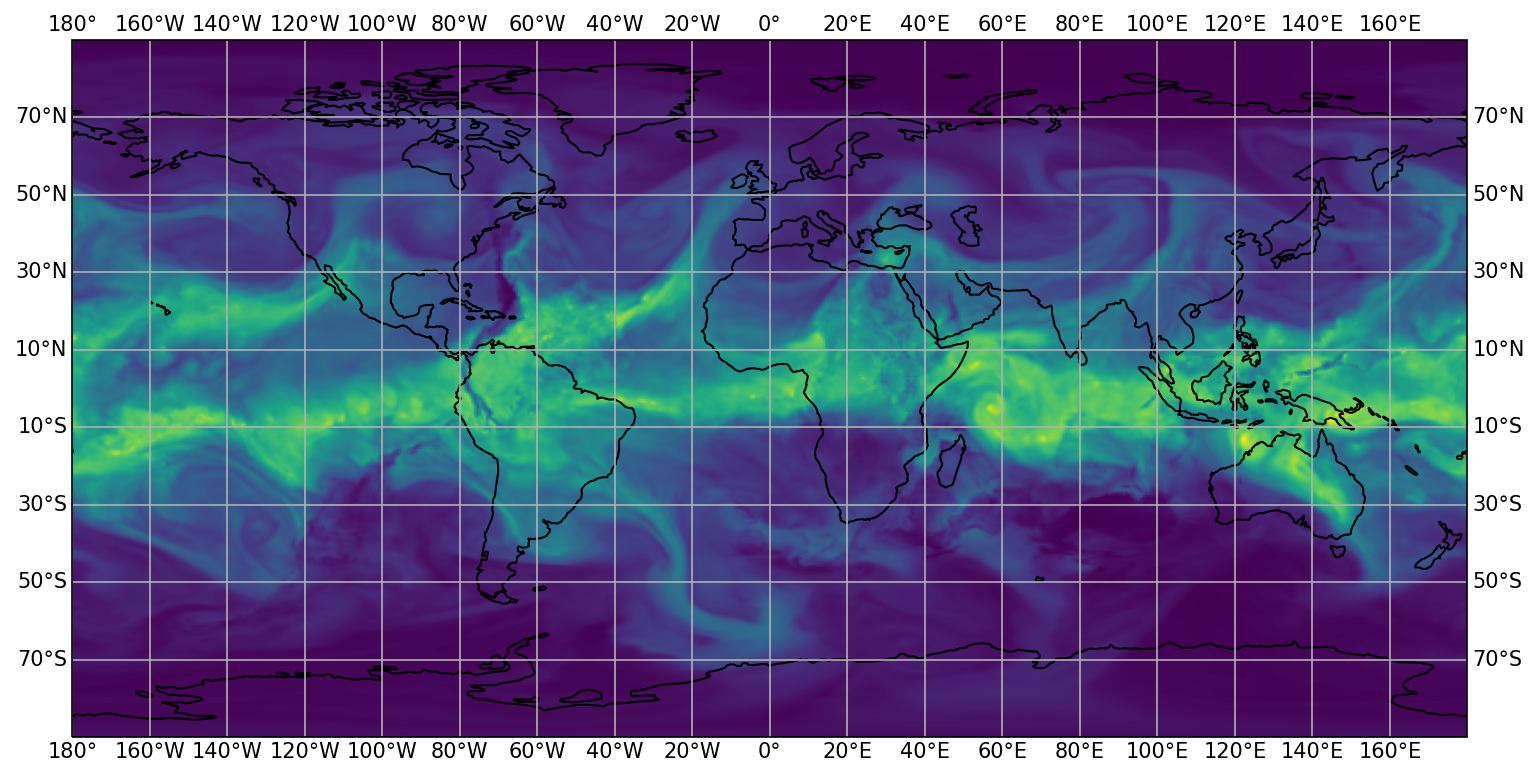

In [10]:
figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=(12,12)),plot_options=plot_options)

proj=figax.plot_options['projection']
# transf=figax.plot_options['transform'] # broken
transf=proj
figax.ax = plt.axes(projection=proj)
figax.ax.set_extent([-180,180,-90,90])
plt.imshow(ds['TQV'][0,:,:],transform=transf,extent=[-180,180,-90,90])
figax.ax.coastlines()
figax.ax.gridlines(draw_labels=True,xlocs=20*numpy.arange(18)-180,ylocs=20*numpy.arange(9)-90)
plt.show()

In [11]:
figax = figax_container(plt.subplots(1,subplot_kw=plot_options,figsize=(12,12)),plot_options=plot_options)
m2_sc=merra2_sidecar(cover_resolution=3)
# m2_sc.cover
plt.imshow(ds['TQV'][0,:,:],transform=transf,extent=[-180,180,-90,90])
hello_plot(m2_sc.cover,figax=figax,show=False,color='red')
figax.ax.coastlines()
figax.ax.gridlines(draw_labels=True,xlocs=20*numpy.arange(18)-180,ylocs=20*numpy.arange(9)-90,color='cyan')
# figax.ax.gridlines(draw_labels=True)
plt.show()

In [12]:
ds.close()

## STARE Cover of a Granule

-- more than just gridded
-- 


In [13]:
files=glob.glob('/home/jovyan/data/*_stare.nc')

In [14]:
files.sort(); files

['/home/jovyan/data/MOD05_L2.A2019336.2315.061.2019337071952_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2320.061.2019337072008_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2325.061.2019337072403_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2330.061.2019337072350_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2335.061.2019337072014_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2340.061.2019337072017_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2345.061.2019337072038_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2350.061.2019337072348_stare.nc',
 '/home/jovyan/data/MOD05_L2.A2019336.2355.061.2019337072028_stare.nc']

In [15]:
figax = hello_plot(set_global=True,show=False
                   ,plot_options = {'projection':ccrs.PlateCarree(central_longitude=170)
                                   ,'transform':ccrs.Geodetic()}
                  ,figsize=(12,12))
for filename in files:
    ds = Dataset(filename)
    cover = ds['STARE_cover_5km'][:].flatten().astype(numpy.int64)
    # cover = ds['STARE_index_5km'][:,:].flatten().astype(numpy.int64)
    # print('ds shape: ',ds['Latitude_5km'].shape)
    ds.close()
    figax = hello_plot(cover,figax=figax,show=False)
plt.show()

In [16]:
files=glob.glob('/home/jovyan/data/*.hdf'); files.sort(); files

['/home/jovyan/data/MOD05_L2.A2019336.2315.061.2019337071952.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2320.061.2019337072008.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2325.061.2019337072403.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2330.061.2019337072350.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2335.061.2019337072014.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2340.061.2019337072017.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2345.061.2019337072038.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2350.061.2019337072348.hdf',
 '/home/jovyan/data/MOD05_L2.A2019336.2355.061.2019337072028.hdf']

In [65]:
file=files[6]
print('loading ',file)
ds = starepandas.SD_wrapper(files[6])

loading  /home/jovyan/data/MOD05_L2.A2019336.2345.061.2019337072038.hdf


In [67]:
lat_5km = starepandas.with_hdf4_get(ds,'Latitude'); lon_5km = starepandas.with_hdf4_get(ds,'Longitude')

img_wvir = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared')
img_wvir,attrs = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared',attrs=['add_offset','scale_factor','_FillValue'])
img_wvir[numpy.where(img_wvir == attrs['_FillValue'])] = 0 # Or use a mask
img_wvir = (img_wvir-attrs['add_offset'])*attrs['scale_factor']

In [20]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(lon_5km,lat_5km,s=0.5,c=img_wvir,transform=ccrs.PlateCarree(),cmap='rainbow')
# ax.set_global()
# ax.set_extent([-50,50,0,90])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.show()

In [21]:
print('closing hdf4 file ',file); ds.end()

closing hdf4 file  /home/jovyan/data/MOD05_L2.A2019336.2345.061.2019337072038.hdf


In [22]:
filename = '/home/jovyan/data/MOD05_L2.A2019336.2345.061.2019337072038_stare.nc'
ds = Dataset(filename)
index2d = ds['STARE_index_5km'][:,:]
ds.close() 
print('shape: ',index2d.shape)

shape:  (406, 270)


In [23]:
cross0=0; cross1= int(270/4)
along0=0; along1= int(406/4)
index = index2d[along0:along1,cross0:cross1].flatten().astype(numpy.int64)

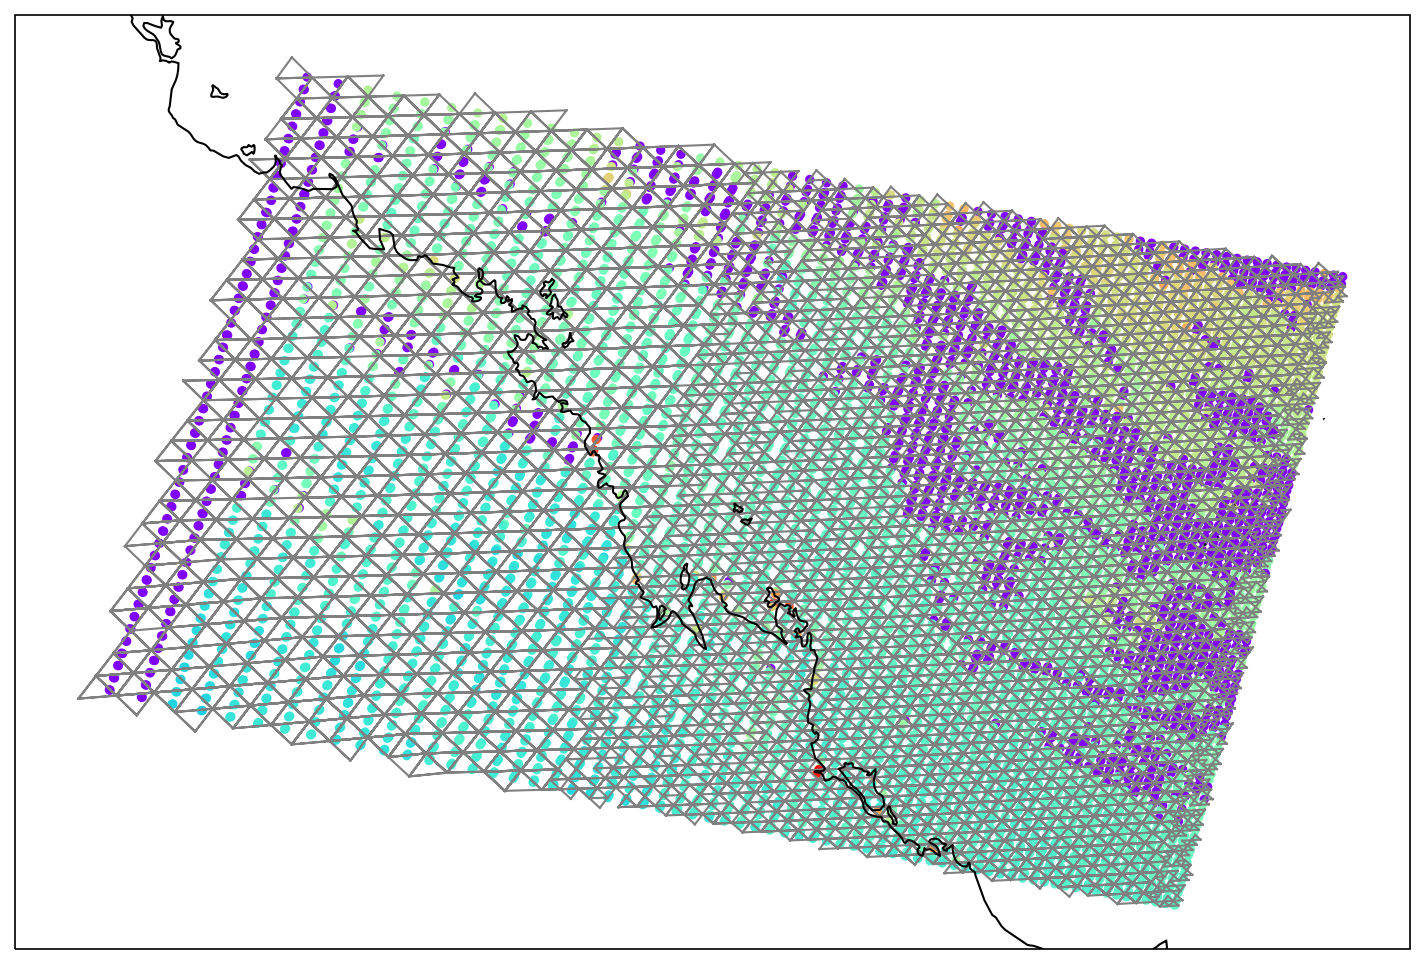

In [24]:
figax = hello_plot(set_global=False,show=False
                   ,plot_options = {'projection':ccrs.PlateCarree(central_longitude=170)
                                   ,'transform':ccrs.Geodetic()}
                  ,figsize=(12,12))
figax = hello_plot(index,figax=figax,show=False,color='grey')
plt.scatter(lon_5km[along0:along1,cross0:cross1],lat_5km[along0:along1,cross0:cross1],s=12,c=img_wvir[along0:along1,cross0:cross1],transform=ccrs.PlateCarree(),cmap='rainbow')

plt.show()



## STARE Region of Interest (ROI)

-- can be multi polygons
-- 

In [25]:
path = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(path)

roi = world[world.continent=='Oceania']

stare = starepandas.stare_from_gdf(roi, level=7, force_ccw=True)
roi = starepandas.STAREDataFrame(roi, stare=stare)

# The trixels are just for visualization
roi.set_trixels(inplace=True)
roi.head()

col:  [[1691242397565976583, 1691277581938065415, 1691347950682243079, 1693071984914595847, 1693142353658773511, 1693177538030862343, 1693212722402951175, 1693318275519217671, 1689553547705712647, 1690257235147489287, 1690362788263755783, 1690538710124199943, 1691242397565976583, 1691946085007753223, 1693071984914595847, 1693212722402951175, 1693318275519217671], [1030761364714422278, 1034842751876726790, 1035124226853437446, 1035405701830148102, 1035687176806858758, 770115536280354823, 770150720652443655, 770185905024532487, 770221089396621319, 770256273768710151, 770291458140798983, 770326642512887815, 770361826884976647, 770537748745420807, 770572933117509639, 770608117489598471, 770643301861687303, 788129934789836807, 788165119161925639, 788200303534014471, 788235487906103303, 788587331626991623, 788622515999080455, 788657700371169287, 1027383664993894407, 1027418849365983239, 1027454033738072071, 1027489218110160903, 1027524402482249735, 1027594771226427399, 1027629955598516231, 1

pop_est continent              name iso_a3  gdp_md_est  \
0     920938   Oceania              Fiji    FJI      8374.0   
7    6909701   Oceania  Papua New Guinea    PNG     28020.0   
89    282814   Oceania           Vanuatu    VUT       723.0   
134   279070   Oceania     New Caledonia    NCL     10770.0   
135   647581   Oceania       Solomon Is.    SLB      1198.0   

                                              geometry  \
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   
7    MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...   
89   MULTIPOLYGON (((167.21680 -15.89185, 167.84488...   
134  POLYGON ((165.77999 -21.08000, 166.59999 -21.7...   
135  MULTIPOLYGON (((162.11902 -10.48272, 162.39865...   

                                                 stare  \
0    [1691242397565976583, 1691277581938065415, 169...   
7    [1030761364714422278, 1034842751876726790, 103...   
89   [1374196020673511431, 1374371942533955591, 137...   
134  [1398965818624049159, 1399141740484493319, 139...   
135  [758328771630596103, 758504693491040263, 75875...   

                                               trixels  
0    (POLYGON ((178.2630517930487 -17.9030132808031...  
7    (POLYGON ((144.7874090166583 -6.02445533704830...  
89   (POLYGON ((167.8392468143006 -16.4682369741067...  
134  (POLYGON ((166.4349709734367 -21.8909500010394...  
135  (POLYGON ((162.0092310794938 -10.9954141373886...

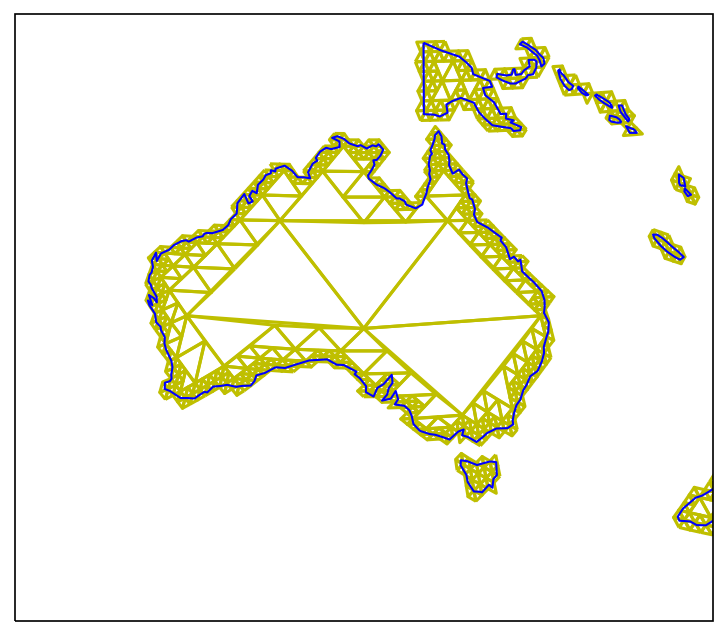

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(6,6))
ax.grid(True)
ax.set_extent([100,170,-50,0],ccrs.Geodetic())
roi.drop(0).plot(ax=ax, trixels=True, boundary=True, color='y', zorder=0) # Drop Fiji
roi.plot(ax=ax, trixels=False, facecolor="none", edgecolor='blue', zorder=1)
plt.show()

## STARE Sidecar Files and Cataloguing

In [27]:
# folder = '/home/jovyan/data/'
folder = 's3://daskhub-data/MODAPS/MOD05/'
catalogue = None
catalogue = starepandas.folder2catalogue(path=folder, 
                             granule_extension='hdf',
                             add_sf=True)


granule_url:  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952.hdf
guessing name:  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952_stare.nc
found names:
 ['MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952_stare.nc']
row:  {'granule_name': 's3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952.hdf', 'sidecar_name': 's3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2315.061.2019337071952_stare.nc', 'stare_cover': masked_array(data=[3985685670222888964, 3990189269850259460,
                   3992441069663944708, ..., 4032418900133019659,
                   4032419037571973131, 4032419175010926603],
             mask=False,
       fill_value=999999), 'begining': datetime.datetime(2019, 12, 2, 23, 15), 'ending': datetime.datetime(2019, 12, 2, 23, 20), 'geom': <shapely.geometry.polygon.Polygon object at 0x7fc84c52ff50>}
granule_url:  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2320.061.2019337072008.hdf
guessing name

In [28]:
catalogue.head()

begining              ending  \
0 2019-12-02 23:15:00 2019-12-02 23:20:00   
1 2019-12-02 23:20:00 2019-12-02 23:25:00   
2 2019-12-02 23:25:00 2019-12-02 23:30:00   
3 2019-12-02 23:30:00 2019-12-02 23:35:00   
4 2019-12-02 23:35:00 2019-12-02 23:40:00   

                                                geom  \
0  POLYGON ((108.04605 87.27840, 109.68678 87.232...   
1  POLYGON ((158.99763 70.64761, 159.02464 70.557...   
2  POLYGON ((159.68237 52.81315, 159.68442 52.722...   
3  POLYGON ((157.96890 34.89169, 157.96465 34.801...   
4  POLYGON ((155.32706 16.94734, 155.31874 16.857...   

                                        granule_name  \
0  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
1  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
2  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
3  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
4  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   

                                        sidecar_name  \
0  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
1  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
2  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
3  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   
4  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...   

                                         stare_cover  
0  [3985685670222888964, 3990189269850259460, 399...  
1  [3566850904877432835, 3503800510094245892, 350...  
2  [3476778912330022915, 3575858104132173828, 357...  
3  [875950127523561476, 887209126591987716, 89171...  
4  [963770320257286147, 941252322120433668, 94800...

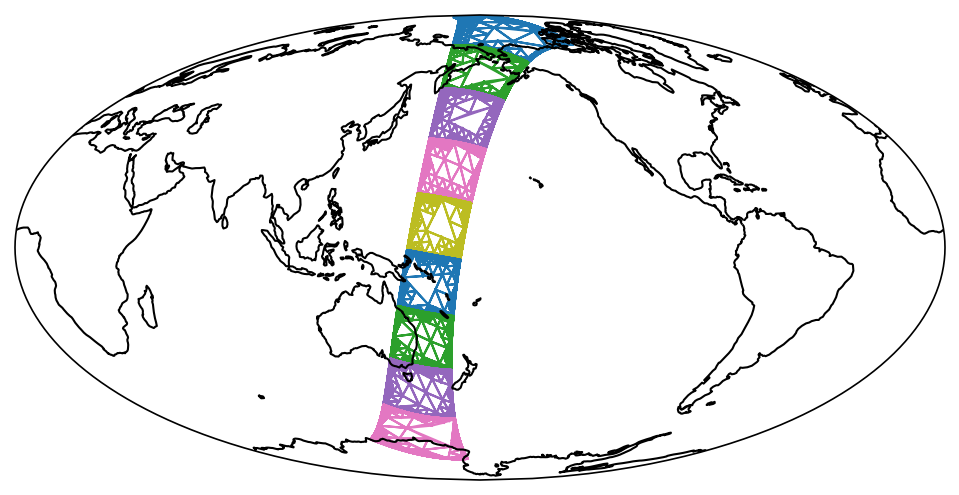

In [29]:
figax=hello_plot(set_global=True,show=False
                 ,plot_options={'projection':ccrs.Mollweide(central_longitude=180),'transform':ccrs.Geodetic()}
                 ,figsize=(8,8)
                )
for i in catalogue['stare_cover']:
    hello_plot(i.data,figax=figax,show=False)
plt.show()

## Searching the Catalogue

In [30]:
roi_stare = roi[roi.name=='Australia'].stare.iloc[0];  # roi_stare

In [31]:
cover_intersects = catalogue.stare_intersects(roi_stare)
granule_subset = catalogue[cover_intersects].granule_name

msg = 'there are {} granules intersecting the ROI'.format(len(granule_subset))
print(msg)
granule_subset.head()

there are 2 granules intersecting the ROI


6    s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...
7    s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A20193...
Name: granule_name, dtype: object

In [32]:
figax=hello_plot(set_global=False,show=False,figsize=(8,8))
hello_plot(roi_stare,figax=figax,show=False)
for i in granule_subset.keys():
    hello_plot(catalogue['stare_cover'][i].data,figax=figax,fixdateline=False,show=False)
plt.show()

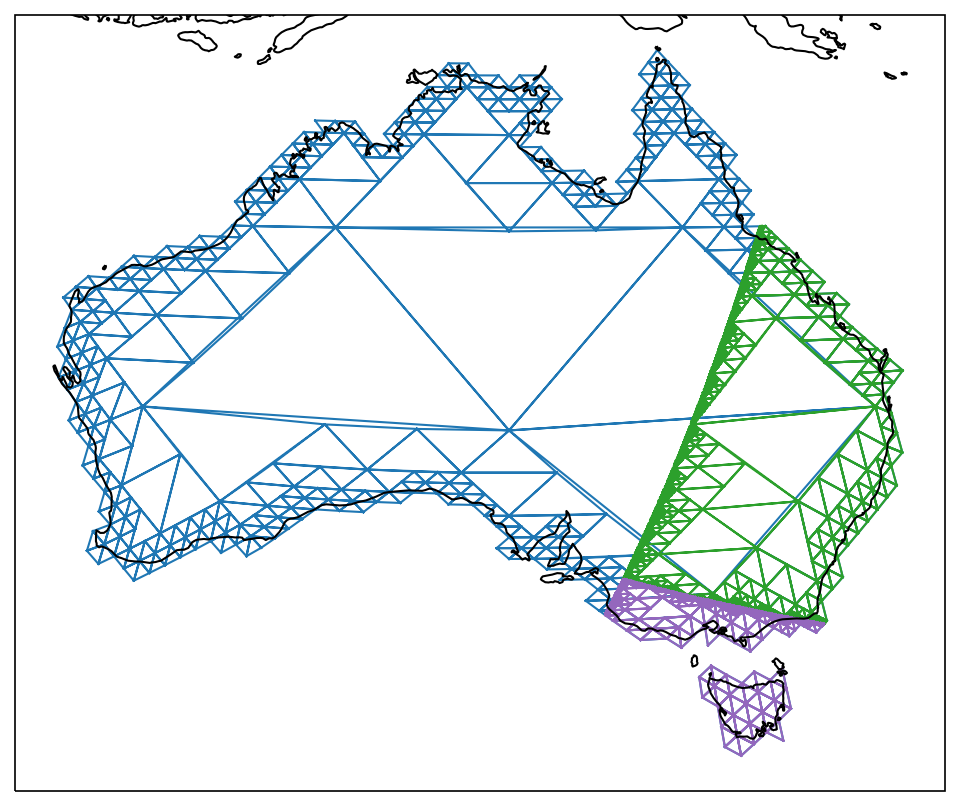

In [33]:
intersections = [
    ps.intersect(roi_stare,catalogue['stare_cover'][i].data,1) for i in granule_subset.keys()
]

figax=hello_plot(set_global=False,show=False,figsize=(8,8))
for cover in [roi_stare]+intersections:
    hello_plot(cover,figax=figax,fixdateline=False,show=False)
plt.show()

## Subsetting the Data

In [68]:
img_wvir_flat      = img_wvir.flatten()
lon_5km_flat       = lon_5km.flatten()
lat_5km_flat       = lat_5km.flatten()

In [41]:
index_flat = index.flatten()

In [86]:
granule_names = list(granule_subset); granule_names

['s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2345.061.2019337072038.hdf',
 's3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2350.061.2019337072348.hdf']

In [138]:
class modis_data(object):
    def __init__(self,file):
    
        print('loading ',file)
        self.file=file
        ds = starepandas.SD_wrapper(file)
        self.lat_5km = starepandas.with_hdf4_get(ds,'Latitude');
        self.lon_5km = starepandas.with_hdf4_get(ds,'Longitude')
        self.img_wvir = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared')
        self.img_wvir,attrs = starepandas.with_hdf4_get(ds,'Water_Vapor_Infrared',attrs=['add_offset','scale_factor','_FillValue'])
        self.img_wvir[numpy.where(img_wvir == attrs['_FillValue'])] = 0 # Or use a mask
        self.img_wvir = (img_wvir-attrs['add_offset'])*attrs['scale_factor']
        ds.end()

        sidecar_file='.'.join(file.split('.')[0:-1])+'_stare.nc'
        print('loading ',sidecar_file)
        self.sidecar_file=sidecar_file
        ds = starepandas.nc4_Dataset_wrapper(sidecar_file)
        self.index2d = ds['STARE_index_5km'][:,:].astype(numpy.int64)
        self.lat2d   = ds['Latitude_5km'][:,:]
        self.lon2d   = ds['Longitude_5km'][:,:]
        ds.close()
        return
    
class modis_subset(object):
    def __init__(self,obj,target_cover):
        self.idx          = ps.intersects(target_cover,obj.index2d.flatten(),1)
        self.subset_idx   = numpy.where(self.idx>0)
        self.subset_cover = obj.index2d.flatten() [self.subset_idx]
        self.subset_lat   = obj.lat2d.flatten()   [self.subset_idx]
        self.subset_lon   = obj.lon2d.flatten()   [self.subset_idx]
        self.subset_wvir  = obj.img_wvir.flatten()[self.subset_idx]
        return
    
    def mnmx(self):
        return numpy.amin(self.subset_wvir),numpy.amax(self.subset_wvir)

In [136]:
data_objs = [modis_data(name) for name in granule_names]

loading  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2345.061.2019337072038.hdf
loading  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2345.061.2019337072038_stare.nc
loading  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2350.061.2019337072348.hdf
loading  s3://daskhub-data/MODAPS/MOD05/MOD05_L2.A2019336.2350.061.2019337072348_stare.nc


In [139]:
intersected_objs = [modis_subset(data_objs[i],intersections[i]) for i in [0,1]]

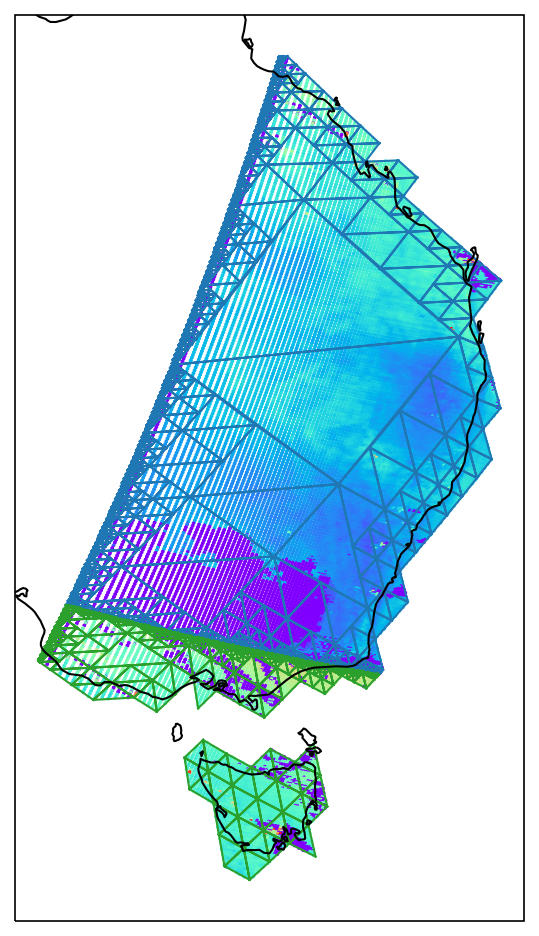

In [142]:
figax = hello_plot(show=False,figsize=(8,8))
figax = hello_plot(intersections[0],show=False,figax=figax)
figax = hello_plot(intersections[1],show=False,figax=figax)
for io in intersected_objs:
    plt.scatter(io.subset_lon,io.subset_lat,s=0.5,c=io.subset_wvir,transform=ccrs.PlateCarree(),cmap='rainbow')

# ax.set_global()
# ax.set_extent([-50,50,0,90])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.show()

## Catalog (reprise)

In [145]:
db_path = '/home/jovyan/data/catalogue.sqlite' 
uri = 'sqlite:///{db_path}'.format(db_path=db_path)
engine = sqlalchemy.create_engine(uri)
cover_intersects = pandas.read_sql(sql='catalogue', con=engine)

# Geometry and STARE are stored in blobs, so we need to deserialize
cover_intersects.stare_cover = cover_intersects.stare_cover.apply(func=numpy.frombuffer, args=('int64',))
cover_intersects.geom = cover_intersects.geom.apply(shapely.wkb.loads, args=(True,))

# We convert the conventional DF to a STAREDataFrame and set the stare column
df = pandas.DataFrame()
cover_intersects = starepandas.STAREDataFrame(df, stare='stare_cover')

col:  stare_cover <class 'str'>


ValueError: Must pass array-like object or column name

## Dask Acceleration

### Dask Preliminaries

### Example Parallelization

### Trixel-based Integration

## Conclusion

-- highlight how few lines of code we need
-- deal with point data -- trajectories, lines, networks, 
-- gridded vs. non-gridded
-- dggs -- 

### How to try STARE out